# Setup

Install the required package and import necessary libraries.

In [2]:
# Install earlier release of matplotlib
# Make sure to restart kernel after this installation
!pip install matplotlib==3.1.0
# Install mcunet for pretrained models
!pip install git+https://github.com/mit-han-lab/mcunet
# Download TinyEngine library for deployment
!wget -O tinyengine.zip "https://hanlab.mit.edu/files/course/labs/tinyengine.zip"
!unzip -o tinyengine.zip
!mv tinyengine/code_generator .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.0-cp310-cp310-linux_x86_64.whl size=12062725 sha256=a04f7ecc2095ca1627c11c43d91219e3ba5c62114889a5d3a5b723287b33eb90
  Stored in directory: /root/.cache/pip/wheels/fd/4d/10/e9efa74676a52fcc2f0a0247d72b9bdb09b4a5f5b4162c0173
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.0 which is incompatible.
mizani 0.8.1 requires matplotlib>=

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mit-han-lab/mcunet to /tmp/pip-req-build-ycr6agel
  Running command git clone --filter=blob:none --quiet https://github.com/mit-han-lab/mcunet /tmp/pip-req-build-ycr6agel
  Resolved https://github.com/mit-han-lab/mcunet to commit c47b6852cf347e1577eb16ae80f4e82c29595ce2
  Preparing metadata (setup.py) ... done
  Created wheel for mcunet: filename=mcunet-0.1.1.post202305261448-py3-none-any.whl size=40494 sha256=2f30212eadc11fa1f9200c0bd169c5a2d8eab13ec134d630026a9735cb952ce8
  Stored in directory: /tmp/pip-ephem-wheel-cache-el1vb3f7/wheels/f4/bf/2c/7d3c17bc107bdaba12873225bda66b1efab5b5797a25e25e60
Successfully built mcunet
--2023-05-26 14:48:03--  https://hanlab.mit.edu/files/course/labs/tinyengine.zip
Resolving hanlab.mit.edu (hanlab.mit.edu)... 18.25.16.171
Connecting to hanlab.mit.edu (hanlab.mit.edu)|18.25.16.171|:443... connected.
HTTP request sent, await

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [4]:
from mcunet.model_zoo import build_model, download_tflite
from code_generator.CodegenUtilTFlite import GenerateSourceFilesFromTFlite
from google.colab import files

Set the seeds to ensure reproducibility of results

In [4]:
torch.manual_seed(42)

# Download a pretrained VWW (Visual Wake Word) model
Let's download the `mcunet-320kb-1mb_imagenet` pretrained model from mcuent. This model will later be deployed in the MCU. You can also download the model from [here](https://hanlab.mit.edu/files/course/labs/lab4/mcunet-5fps_vww.tflite).

Visual Wake Words is a common microcontroller vision use-case for identifying whether a person is present in the image or not, and provides a realistic benchmark for tiny vision models.

Please refer to the [model zoo](https://github.com/mit-han-lab/mcunet#model-list) of mcunet for more detailed statistics of the model.



In [5]:
model, image_size, description = build_model(net_id="mcunet-in3", pretrained=True) 
tflite_path = download_tflite(net_id="mcunet-in3")
files.download(tflite_path)

Downloading: "https://hanlab.mit.edu/projects/tinyml/mcunet/release/mcunet-320kb-1mb_imagenet.json" to /root/.torch/mcunet/mcunet-320kb-1mb_imagenet.json
Downloading: "https://hanlab.mit.edu/projects/tinyml/mcunet/release/mcunet-320kb-1mb_imagenet.pth" to /root/.torch/mcunet/mcunet-320kb-1mb_imagenet.pth
Downloading: "https://hanlab.mit.edu/projects/tinyml/mcunet/release/mcunet-320kb-1mb_imagenet.tflite" to /root/.torch/mcunet/mcunet-320kb-1mb_imagenet.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model visualization


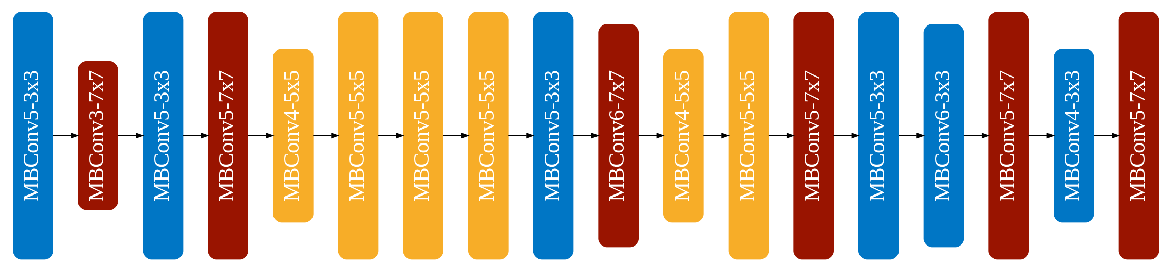

In [6]:
from tinyengine.arch_visualization_helper import visualize_model
visualize_model(model)

To further investigate the vww model, we can use Netron, a cross-platform tool, to visualizing layer-wise information.

1.   Visualize the downloaded model through [Netron](https://github.com/lutzroeder/netron). You can either install it locally or use their [browser version](https://netron.app/).
2.   In Netron, click `Open Model...` to visualize the model downloaded to your PC.

After opening the model with Netron, you can explore the model in great detail. For example, you can see the information of properties, attributes, inputs, and outputs of a convolution layer by clicking the node as below.

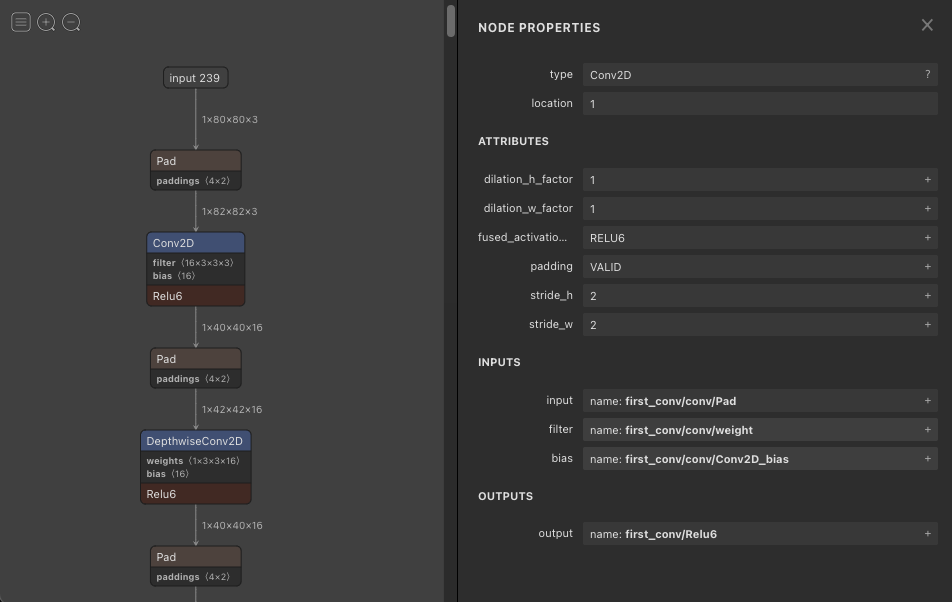




## Question 1: Neural Architecture (10pts)

How many depthwise and pointwise convolution layers (1x1) are there in the `mcunet-320kb-1mb_imagenet` model? Please refer to the visualization result from Netron.

Your Answer:

1. Number of depthwise conlution layers: 15
2. Number of pointwise convolution layers: 30

# Deployment with TinyEngine



Introduction of TinyEngine, a memory-efficient inference library. TinyEngine adapts the memory scheduling according to the overall network topology rather than layer-wise optimization, reducing the memory usage and accelerating the inference. It outperforms existing inference libraries such as TF-Lite Micro from Google and CMSIS-NN from ARM.

TinyEngine adopts the folloing optimization techniques to acclerate infernece and minmize memory footprint.

*   [**Loop reordering**](https://xilinx.github.io/Vitis_Accel_Examples/2019.2/html/loop_reorder.html): A loop transformation technique that attempts to optimize a program's execution speed by reordering/interchanging the sequence of loops.
*   [**Loop unrolling**](https://en.wikipedia.org/wiki/Loop_unrolling): A loop transformation technique that attempts to optimize a program's execution speed at the expense of its binary size, which is an approach known as space-time tradeoff.
*   [**SIMD (Single instruction, multiple data) instructions**](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data): A computing method that enables processing of multiple data with a single instruction.
*   [**Image to Column (Im2col) convolution**](https://iq.opengenus.org/im2col/): An implementation technique of computing convolution operation using general matrix multiplication (GEMM) operations.
*   [**HWC to CHW weight format transformation**](https://oneapi-src.github.io/oneDNN/dev_guide_understanding_memory_formats.html): A weight format transformation technique that increases cache hit ratio for in-place depth-wise convolution.
*   [**In-place depth-wise convolution**](https://mcunet.mit.edu/#mcunetv1): A unique data placement technique for depth-wise convolution that overwrites input data by intermediate/output data to reduce peak SRAM memory.

Please refer to the TinyEngine [GitHub](https://github.com/mit-han-lab/tinyengine) and the MCUNet [website](https://mcunet.mit.edu/) for more information.



Now we will generate C source files for the model using TinyEngine for on-device deployment. You can change the `optimization_config` to turn on/off optimization techniques.

TinyEngine derives the memory schedules for each activation tensor. It will output the number of activation tensors and memory footprint as a figure for visualization.




Deriving the memory schedule for 50 activation tensors.


100%|██████████| 50/50 [00:00<00:00, 27335.14it/s]


---------------- Operator-Tensor Mapping ----------------
 #op |   operator type   | input tensor | output tensor |
#0   |CONV_2D            |0             |1              |
#1   |DEPTHWISE_CONV_2D  |1             |1              |
#2   |CONV_2D            |1             |2              |
#3   |CONV_2D            |2             |3              |
#4   |DEPTHWISE_CONV_2D  |3             |3              |
#5   |CONV_2D            |3             |4              |
#6   |CONV_2D            |4             |5              |
#7   |DEPTHWISE_CONV_2D  |5             |5              |
#8   |CONV_2D            |5             |6              |
#9   |ADD                |6,4           |7              |
#10  |CONV_2D            |7             |8              |
#11  |DEPTHWISE_CONV_2D  |8             |8              |
#12  |CONV_2D            |8             |9              |
#13  |ADD                |9,7           |10             |
#14  |CONV_2D            |10            |11             |
#15  |DEPTHWIS

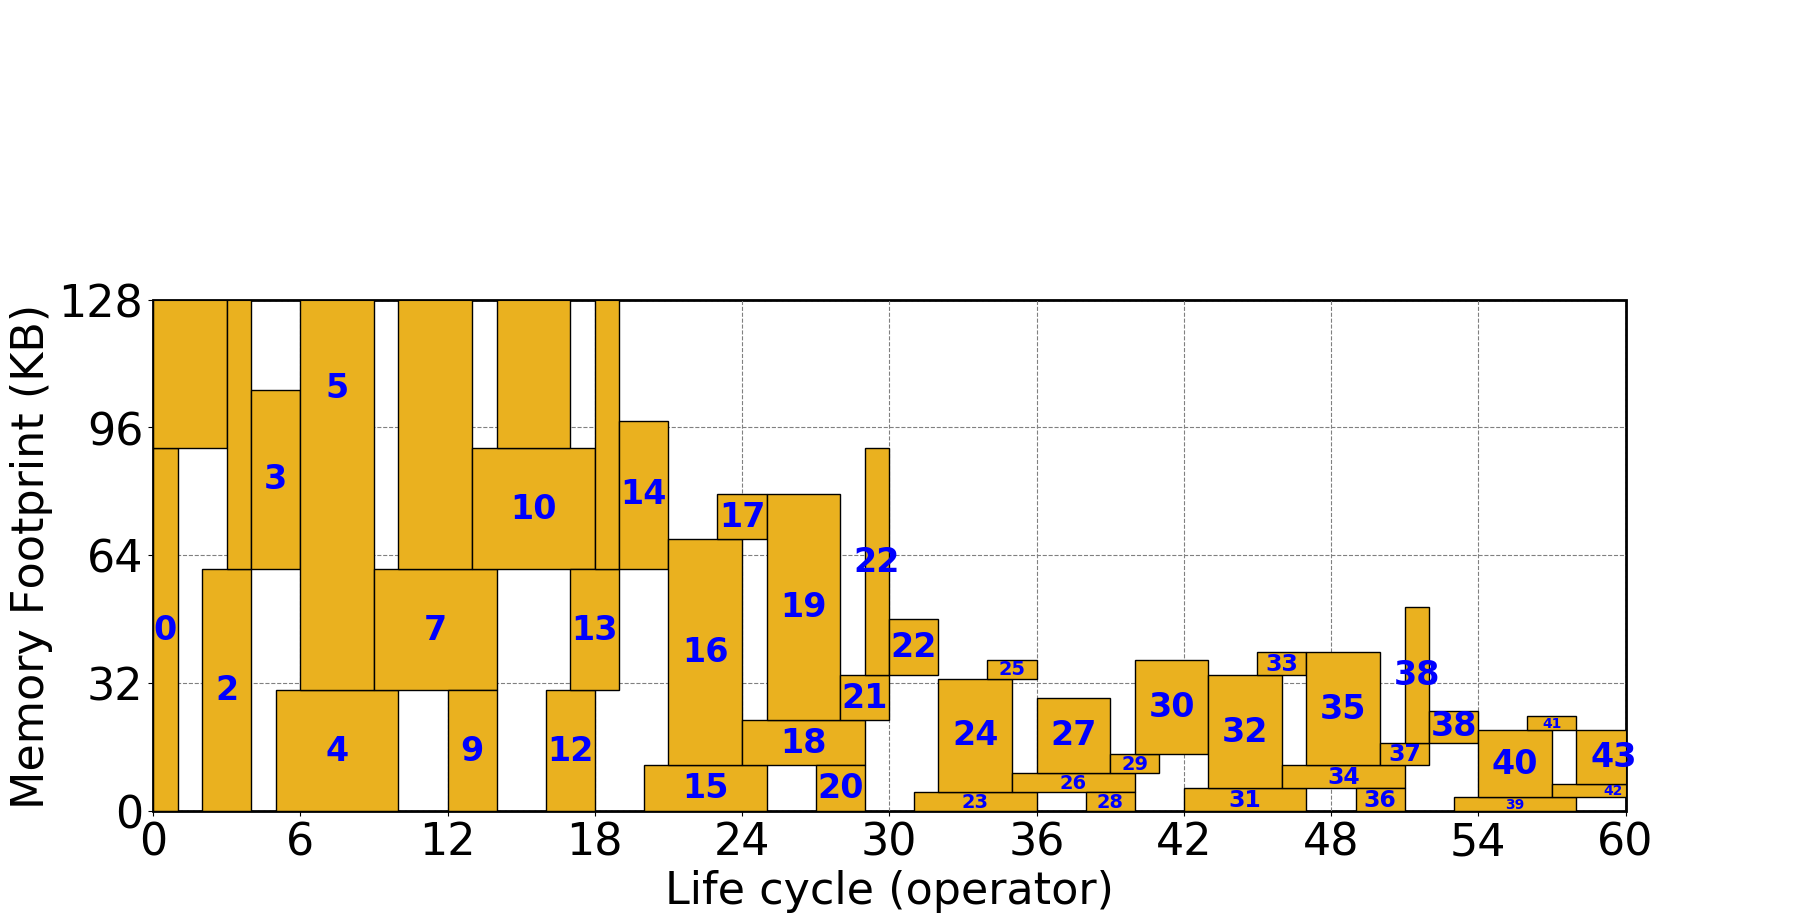

In [7]:
############### YOUR CODE STARTS HERE ###############
optimization_config = {
    "loop_reordering": True, # Enable loop reordering optimization
    "im2col": True, # Enable im2col convolution
    "hwc2chw_weight": True, # Enable HWC -> CHW format transformation for weights
    "loop_unrolling": True, # Enable loop unrolling optimization
    "simd": True, # Enable SIMD programming
    "inplace_depthwise": True, # Enable inplace depthwise convolution
}
############### YOUR CODE ENDS HERE ###############
tensor_lfe_cycle_path = "./lifecycle.png"
peakmem = GenerateSourceFilesFromTFlite(
    tflite_path,
    life_cycle_path=tensor_lfe_cycle_path,
    custom_optimization_config=optimization_config,
)
print(f"Peak memory: {peakmem} bytes")

## Question 2: Memory Reduction of In-place Depthwise Convolution (20pts)

Please change the `optimization_config` to enable/disable in-place depthwise convolution and evaluate the memory reduction from in-place depthwise convolution.

### Question 2.1: Peak Memory (10pt)

What are peak memory and number of activation tensors before and after enabling in-place depthwise update?

Your Answer:

Before enabling in-place depthwise update, the peak memory is: 418176 bytes

After enabling in-place depthwise update, the peak memory is: 247808 bytes

Before enabling in-place depthwise update, the number of activation tensors is: 68

After enabling in-place depthwise update, the number of activation tensors is: 50

### Question 2.2: Memory Bottleneck (10pt)

Which tensor leads to the memory bottleneck before and after enabling in-place depthwise update? Please specify its tensor id.

Your Answer:

Before enabling in-place depthwise update, the memory bottleneck tensor is: (tensorid = 15)

After enabling in-place depthwise update, the memory bottleneck tensor is: (tensorid = 5)

##Let's learn how the optimization techniques are realized in Tiny Inference Engine.

Nomenclature of the files linked in Q3 is as follows. 
For example, `convolve_1x1_s8.c` indicates it is a pointwise (1x1 kernel size) convolution operator, and `depthwise_kernel3x3_stride1_inplace_CHW.c` indicates it is a depthwise convolution operator with 3x3 kernel size and stride 1.

Take `convolve_1x1_s8_fpreq.c` as an example, which is linked in Q3.1. In this file, you will find that we use multiple "[macros](https://www.programiz.com/c-programming/c-preprocessor-macros)" to switch on/off different optimization techniques. For instance, it will execute Lines 36-61 when `loop_reordering` is set as False.

Please review the optimization techniques introduced in the Lectures and further look at the code files linked in questions below to learn how the optimization techniques are realized and why the speed/memory footprint can be improved in Tiny Inference Engine.

In [ ]:
# The following code snippet is for demonstration and not runnable on Colab / Jupyterhub
#if (!LOOP_REORDERING) 
  /* Similar to TF-Lite Implementation */
	for (int out_y = 0; out_y < output_y; ++out_y) {
		for (int out_x = 0; out_x < output_x; ++out_x) {
			for (int out_channel = 0; out_channel < output_ch; ++out_channel) {
				int32_t sum = 0;
				for (int filter_y = 0; filter_y < DIM_KER_Y; ++filter_y) {
					for (int filter_x = 0; filter_x < DIM_KER_X; ++filter_x) {
						for (int in_channel = 0; in_channel < input_ch; ++in_channel) {
							int32_t input_val = input[Offset(input_y, input_x, input_ch, 0, out_y, out_x, in_channel)];
							int32_t filter_val = kernel[Offset(DIM_KER_Y, DIM_KER_X, input_ch, out_channel, filter_y, filter_x, in_channel)];
							sum += filter_val * (input_val + input_offset);
						}
					}
				}

				if (bias) {
					sum += bias[out_channel];
				}
				sum = (int32_t) ((float)sum * scales[out_channel]);
				sum += out_offset;
				sum = MAX(sum, out_activation_min);
				sum = MIN(sum, out_activation_max);

				output[Offset(output_y, output_x, output_ch, 0, out_y, out_x, out_channel)] = (int8_t)(sum);
			}
		}
	}

## Question 3: Please read the code files linked in the questions and answer following questions. (35pts)

Hint: The source code uses `#if`, `#elif`, and `#endif` to control which portions of the source file are compiled. More detailed information can be found [here](https://docs.microsoft.com/en-us/cpp/preprocessor/hash-if-hash-elif-hash-else-and-hash-endif-directives-c-cpp?view=msvc-170).

### Question 3.1:  In [convolve_1x1_s8_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/convolve_1x1_s8_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `loop_unrolling` and `simd`? (8pt)

Your Answer:line 1 to 34(compulsory), loop_ordering : line 65 to 72, loop_unrolling : lines 101 to 353, SIMD : lines 273 to 353

### Question 3.2:  In [depthwise_kernel3x3_stride1_inplace_CHW_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/depthwise_kernel3x3_stride1_inplace_CHW_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `im2col`, `hwc2chw_weight`, `loop_unrolling` and `inplace_depthwise`? (9pt)

**Your Answer:**

Your Answer: line 1 to 39(compulsory), Loop_ordering: line 78 to 170, im2col : line 113 to 149, inplace_depthwise : line 154, 168, hwc2chw weight : line 162, loop_urolling: line 243 to 312

### Question 3.3: In [convolve_1x1_s8_ch48_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/convolve_1x1_s8_ch48_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering` and `loop_unrolling`? (9pt)


Your Answer: lines 1 to 30 (compulsory), loop_ordering : line 61 to 895, loop_unrolling : line 98 to 895

### Question 3.4: In [depthwise_kernel7x7_stride2_inplace_CHW_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/depthwise_kernel7x7_stride2_inplace_CHW_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `im2col` and `hwc2chw_weight`? (9pt)


Your Answer: lines 1 to 39, 188 to 195 (compulsory), loop_reordering: line 78 to 179, im2col : line 113 to 179, hwc2chw_weight : line 170, 225 to 451

# Knowledge Distillation


We will use Resnet18 as teacher and student models and CIFAR-10 dataset for this section of the lab.

Load the pretrained model and the CIFAR-10 dataset

In [6]:
# Define the teacher model
teacher_model = resnet18(pretrained=True)
teacher_model.fc = nn.Linear(512, 10)  # Modify the last layer for your task

# Define the student model
student_model = resnet18()
student_model.fc = nn.Linear(512, 10)  # Modify the last layer for your task

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)

# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 79816439.92it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


## Question 4 (20 pts)

Please complete the following code for:


*   Teacher model
*   Distillation Loss function
*   Student model with knowledge distillation
*   Student model without knowledge distillation





In [7]:
# Train the teacher model (fine-tuning)

for epoch in range(5): 
    running_loss = 0.0
    for inputs, labels in train_loader:

      ### Your code starts here! ###

        outputs = teacher_model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
      ### Your code ends here! ###

    print(f'Teacher Model - Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Define the distillation loss function
def distillation_loss(outputs, labels, teacher_outputs, temperature):

  # Hint: Use Softmax function
  ### Your code starts here! ###
    # Apply softmax to teacher and student outputs
    soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
    student_probs = nn.functional.softmax(outputs / temperature, dim=1)

    # Compute the Kullback-Leibler divergence loss   
    loss = nn.KLDivLoss(reduction='batchmean')(student_probs.log(), soft_targets)
    return loss

# Train the student model with knowledge distillation
temperature = 3  
for epoch in range(5):  
    running_loss = 0.0
    for inputs, labels in train_loader:

      ### Your code starts here! ###

        # Forward pass
        teacher_outputs = teacher_model(inputs)
        student_outputs = student_model(inputs)
        # Calculate the distillation loss
        loss = distillation_loss(student_outputs, labels, teacher_outputs, temperature)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      
      ### Your code ends here! ###

    print(f'Student Model (with Distillation) - Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Train the student model from scratch (without distillation)
student_model = resnet18()
student_model.fc = nn.Linear(512, 10)  

optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(5): 
    running_loss = 0.0
    for inputs, labels in train_loader:

      ### Your code starts here! ###

        
        # Forward pass
        outputs = student_model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
      ### Your code ends here! ###

    print(f'Student Model (without Distillation) - - Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}')


Teacher Model - Epoch: 1, Loss: 2.5968057847083985
Teacher Model - Epoch: 2, Loss: 2.5970352503954603
Teacher Model - Epoch: 3, Loss: 2.593549543329517
Teacher Model - Epoch: 4, Loss: 2.5925100596664508
Teacher Model - Epoch: 5, Loss: 2.59207178503656
Student Model (with Distillation) - Epoch: 1, Loss: 0.0356980381828859
Student Model (with Distillation) - Epoch: 2, Loss: 0.030398177507016663
Student Model (with Distillation) - Epoch: 3, Loss: 0.02835476311528698
Student Model (with Distillation) - Epoch: 4, Loss: 0.027373565944469037
Student Model (with Distillation) - Epoch: 5, Loss: 0.026592511717049058
Student Model (without Distillation) - - Epoch: 1, Loss: 1.5910828656247815
Student Model (without Distillation) - - Epoch: 2, Loss: 1.237121555811304
Student Model (without Distillation) - - Epoch: 3, Loss: 1.0444552915175553
Student Model (without Distillation) - - Epoch: 4, Loss: 0.8842757793186266
Student Model (without Distillation) - - Epoch: 5, Loss: 0.7544167708710331


## Question 5 (15 pts)

The last code cell performs training of student models with and without knowledge distillation. 

Given this observation, please answer the following questions.

### Question 5.1 (5 pts)

How is the performance of student model with knowledge distillation compared to without distillation? Analyze their loss values over epochs and discuss the impact of knowledge distillation on model training.


   Loss Values:
   - The loss values of the student model with knowledge distillation are consistently lower compared to the student model without distillation. This indicates that the student model benefits from knowledge distillation during training, as it helps improve its performance in terms of minimizing the loss.

   - The loss values of the student model with distillation gradually decrease across epochs, indicating that the model is learning and converging towards better performance.
   - In contrast, the loss values of the student model without distillation are initially higher and decrease over time, but they remain higher than those of the student model with distillation. This suggests that the student model primarily relying on ground truth labels alone takes more time to achieve comparable performance.

Impact of Knowledge Distillation:
   - Knowledge distillation allows the student model to leverage the knowledge learned by the teacher model, improving its performance by incorporating the teacher's predictions.
   - By distilling the teacher model's knowledge into the student model, the student model can benefit from the teacher's insights and generalize better, even if the teacher model is more complex or accurate.
   - The distillation process helps the student model learn from the teacher's soft targets, which are typically more informative and contain additional information compared to the ground truth labels alone. This additional guidance helps the student model make more confident and accurate predictions.

Overall, the use of knowledge distillation demonstrates its positive impact on model training. The student model with knowledge distillation outperforms the one without distillation, as reflected by the consistently lower loss values. Knowledge distillation enables the transfer of knowledge from a more knowledgeable teacher model to a less complex student model, enhancing the student model's performance and accelerating its learning process.

### Question 5.2 (5 pts)

What is the role of the distillation loss function in knowledge distillation? How does it differ from the standard cross-entropy loss function?

The distillation loss function plays a crucial role in knowledge distillation. It differs from the standard cross-entropy loss function by incorporating the knowledge from the teacher model into the training of the student model. Here's a breakdown of the role and differences between the two loss functions:

1. Standard Cross-Entropy Loss Function:
   - The standard cross-entropy loss function is commonly used for classification tasks and measures the discrepancy between the predicted probabilities and the true labels.
   - It computes the loss by comparing the predicted probability distribution (output of the student model) with the one-hot encoded ground truth labels.
   - The cross-entropy loss function encourages the student model to align its predictions with the ground truth labels during training.
   - It focuses solely on optimizing the student model's ability to match the ground truth labels without considering other sources of information.

2. Distillation Loss Function:
   - The distillation loss function is specific to knowledge distillation and incorporates the knowledge from the teacher model into the training of the student model.
   - Instead of comparing the student's predictions with the one-hot encoded ground truth labels, the distillation loss function compares the student's predictions with the softened (or "soft targets") predictions of the teacher model.
   - The soft targets represent the teacher model's confidence distribution over the classes, which are typically obtained by applying a temperature scaling factor to the logits and then normalizing them using the softmax function.
   - The distillation loss function encourages the student model to align its predictions not only with the ground truth labels but also with the teacher's knowledge, providing additional guidance during training.
   - By incorporating the knowledge from the teacher model, the distillation loss function enables the student model to learn from the teacher's insights, make more confident predictions, and generalize better.

Thus, the distillation loss function extends the standard cross-entropy loss by incorporating the knowledge of the teacher model. It encourages the student model to learn not only from the ground truth labels but also from the soft targets produced by the teacher model. This allows the student model to benefit from the teacher's knowledge and improve its performance by making more informed predictions.

### Question 5.3 (5 pts)

Does increasing the number of epochs to 10 bring a difference in performance of student models with and without knowledge distillation? If so, analyze and discuss the difference in performance of the models in detail. 

Observations and Analysis:
1. Performance Difference: 
   - Initially, even with knowledge distillation, the student model's loss is significantly lower compared to the model without distillation. This indicates that knowledge distillation helps the student model learn more efficiently and improve its predictions.
   - As the number of epochs increases, the difference in performance between the two models becomes more pronounced. The student model with distillation continues to achieve lower loss values, while the model without distillation lags behind.
   - The decreasing trend of the loss values in both cases suggests that both models are learning and improving over time. However, the model with distillation consistently outperforms the one without distillation.

2. Convergence Speed:
   - The student model with distillation reaches a lower loss value in the initial epochs itself and continues to converge towards better performance. This suggests that knowledge distillation provides a head start by leveraging the teacher's guidance.
   - In contrast, the student model without distillation starts with a higher loss value and takes longer to converge. It requires more epochs to achieve comparable performance, indicating that it relies solely on the ground truth labels for learning.

3. Generalization and Stability:
   - The consistent lower loss values of the student model with distillation indicate better generalization and stability. By incorporating the teacher's knowledge, the model gains insights into the data distribution and improves its predictions.
   - The model without distillation, although improving, might experience challenges in generalizing to unseen data due to relying solely on the ground truth labels.

Overall, increasing the number of epochs to 10 further highlights the difference in performance between the student models with and without knowledge distillation. The model with distillation maintains a clear advantage by achieving lower loss values and faster convergence. This demonstrates the effectiveness of knowledge distillation in enhancing the student model's learning process, promoting generalization, and accelerating its ability to make accurate predictions.